(probabilistic_networks)=
# Creating and manipulating networks of probabilistic nodes

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/0.2-Creating_networks.ipynb)

In [1]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyhgf.model import Network, HGF
from pyhgf.typing import AdjacencyLists

plt.rcParams["figure.constrained_layout.use"] = True

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[pyhgf](https://ilabcode.github.io/pyhgf/index.html#) is designed with inspiration from graph neural network libraries that can support message-passing schemes and perform belief propagation through networks of probabilistic nodes. Here, this principle is applied to predictive processing and focuses on networks that are structured as **rooted trees** and perform variational message passing to update beliefs about the state of the environment, inferred from the observations at the root of the tree. While this library is optimized to implement the standard two-level and three-level HGF {cite:p}`2011:mathys,2014:mathys`, as well as the generalized HGF {cite:p}`weber:2023`, it can also be applied to much larger use cases, with the idea is to generalize belief propagation as it has been described so far to larger and more complex networks that will capture a greater variety of environmental structure. Therefore, the library is also designed to facilitate the creation and manipulation of such probabilistic networks. Importantly, here we consider that a probabilistic network should be defined by the following four variables:
1. the network parameters
2. the network structure
3. the update function(s)
4. the update sequence(s)
Splitting the networks this way makes the components easily compatible with JAX main transformations, and dynamically accessible during the inference processes, which allows the creation of agents that can manipulate these components to minimize surprise.

In this notebook, we dive into the details of creating such networks and illustrate their modularity by the manipulation of the four main variables.

## Theory and implementation details

A let $\mathcal{N}_{k} = \{\theta, \xi, \mathcal{F}, \Sigma \}$ be a probabilistic network with $k$ probabilistic nodes. The variable

$$\theta = \{\theta_1, ..., \theta_{k}\}$$

is the parameter set, and each parameter is a set of real values. Nodes' parameters can be used to register sufficient statistics of the distributions as well as various coupling weights. This component is registered as the `attributes` dictionary.

The *shape* of the hierarchical structure is defined by its [adjacency list](https://en.wikipedia.org/wiki/Adjacency_list), which registers the connections between a node and other nodes from the network.

$$\xi = \{\xi_1, ..., \xi_{k} \}$$

where every edge $\xi_k$ contains $m$ sets of node indexes, $m$ being the adjacency dimension (here we only consider value and volatility coupling, therefore $m=2$).

The way beliefs are being updated, or the type of generic computation that is performed by the nodes are defined by the set of $n$ update functions

$$\mathcal{F} = \{f_1, ..., f_n\}$$

In this set, each update function is linked to a node from the node indexes $n \in 1, ..., k$ to which the function should apply. The most standard uses of the HGF only require continuous and/or binary update functions for input and states node that can be found in the {py:func}`pyhgf.updates` sub-module.

The dynamic of belief propagation dynamics (which part of the network should be updated and in which order) are controlled by the ordered update sequence

$$\Sigma = [f_1(n_1), ..., f_i(n_j), f \in \mathcal{F}, n \in 1, ..., k ]$$

This list describes the sequence of function-to-nodes instructions that are executed during the inference and update processes.

![graph_network](../images/graph_network.svg)

```{tip} Compatibility with JAX transformations
One of the advantages of reasoning this way is that it dissociates variables that are transparent to the JAX framework and can be expressed as "PyTress" from variables that should be filtered before transformations. The variable `attributes` ($\theta$) is typically expressed as a PyTree while the other variables that contain parametrized functions are filtered. See [the documattion](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#jit-mechanics-tracing-and-static-variables) for further details on JAX transformations.
```

### Creating probabilistic nodes

In [3]:
parameters = {"mean": 0.0, "precision": 1.0}

attributes = (parameters, parameters, parameters)
edges = (
    AdjacencyLists(0, (1,), None, None, None, (None,)),
    AdjacencyLists(2, None, (2,), (0,), None, (None,)),
    AdjacencyLists(2, None, None, None, (1,), (None,)),
)

The code above illustrates creating a probabilistic network of 3 nodes with simple parameter sets $(mean = 0.0, precision = 1.0)$. Node 2 is the value parent of node 1. Node 3 is the value parent of node 2 and has no parents. The first integer of the `AdjacencyLists` represents the node type (here `0` for continuous inputs and `2` for continuous state nodes).

### Visualizing probabilistic networks

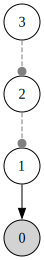

In [4]:
# create a three-level HGF using default parameters
hgf = HGF(n_levels=3, model_type="continuous")
hgf.plot_network()

## Modifying the attributes

The simpler change we can make on a network is to change the values of some of its parameters. The parameters are stored in the `attributes` variable as a dictionary where the key (integers) are node indexes. Therefore, modifying the precision of the third node in the previous example is as simple as:

In [5]:
hgf.attributes[3]["precision"] = 5.0

It is also possible to initialize the network with given attribute values. You can provide additional parameters by using the `node_parameters` arguments in {py:meth}`pyhgf.model.add_nodes`, or simply by passing additional keyword arguments. When using keyword arguments, the key should match with the existing keys found in the node's attributes. This is not a requirement when passing values using `node_parameters`.

In [6]:
# method 1
new_input_precision_1 = Network().add_nodes(
    precision=10.0
)

# method 2
new_input_precision_2 = Network().add_nodes(
    node_parameters={"precision": 10.0}
)

# both methods change the default values, but only method 2 will create a new key without error
assert (
    new_input_precision_1.attributes[0]["precision"]
    == new_input_precision_2.attributes[0]["precision"]
)

However, modifying parameter values *manually* should not be that common as this is something we want the model to perform dynamically as we present new observations, but this can be used for example to generate prior predictive by sampling some parameter values from a distribution.

```{note} What is a valid parameter/value?
A probabilistic node can store an arbitrary number of parameters. Parameter values should be valid JAX types, therefore a node cannot contain strings. Most of the nodes that are being used in the HGF use Gaussian distribution, therefore they contain the current mean and precision (`mean` and `precision`) as well as the expected mean and precision (`expected_mean` and `expected_precision`).
```

## Modifying the edges

The second way we can modify a probabilistic network is by modifying its structure (i.e. the number of nodes, the type of nodes and the way they are connected with each other). Because nodes and connections are modular, a large variety of network structures can be declared. The only restrictions are that the network should be **acyclic** and **rooted** (the roots being input nodes).

For example, the following networks are valid HGF structures:

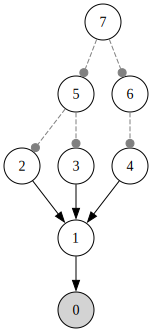

In [7]:
a_custom_hgf = (
    Network()
    .add_nodes()
    .add_nodes(value_children=0)
    .add_nodes(value_children=1, n_nodes=3)
    .add_nodes(volatility_children=[2, 3])
    .add_nodes(volatility_children=4)
    .add_nodes(volatility_children=[5, 6])
)
a_custom_hgf.plot_network()

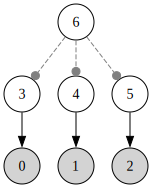

In [8]:
another_custom_hgf = (
    Network()
    .add_nodes(n_nodes=3)
    .add_nodes(value_children=0)
    .add_nodes(value_children=1)
    .add_nodes(value_children=2)
    .add_nodes(volatility_children=[3, 4, 5])
)
another_custom_hgf.plot_network()

The structure of the probabilistic network is stored in the `edges` variable which consists of a tuple of `ContingencyLists` that store the indexes of value/volatility parents/children for each node. For example, accessing the nodes connected to node `4` in the example above is done with:

In [9]:
# the node structure
another_custom_hgf.edges[4]

AdjacencyLists(node_type=2, value_parents=None, volatility_parents=(6,), value_children=(1,), volatility_children=None, coupling_fn=(None,))

```{tip} Different types of coupling
Contrary to standard graph networks, the directed connection between nodes can have multiple forms. The standard HGF is built on combinations of *value coupling* and *volatility coupling* bindings, but this can be extended to an arbitrary number of types.
```

### Multivariate coupling

As we can see in the examples above, nodes in a valid HGF network can be influenced by multiple parents (either value or volatility parents). Similarly, a single node can be influenced by multiple children. This feature is termed *multivariate descendency* and *multivariate ascendency* (respectively) and is a central addition to the generalization of the HGF {cite:p}`weber:2023` that was implemented in this package, as well as in the [Julia counterpart](https://github.com/ilabcode/HierarchicalGaussianFiltering.jl).

```{note}
Hierarchical Gaussian Filters have often been described in terms of levels. For example, the two-level and three-level HGFs are specific instances of  node structures designed to track the volatility and meta-volatility of binary or continuous processes, respectively. While such models can easily be implemented in this framework, the notion of level itself is now less informative. This is a consequence of the multivariate control and influence properties, which can result in structures in which some nodes have a position in the hierarchy that cannot be clearly disambiguated.
```

#### The case of *multivariate descendency*

*Multivariate descendency* refers to situations where a node exerts a predictive influence (and is updated backwards through prediction errors) on multiple children nodes, either via value or volatility coupling.

##### Continuous value coupling

In [10]:
# simulate some time series - one Gaussian noise and one noisy in wave
u_0 = np.random.normal(0, 0.5, size=1000)
u_1 = np.sin(np.arange(0, 1000) / 30) * 8 + np.random.normal(0, 0.5, size=1000)

input_data = np.array([u_0, u_1]).T

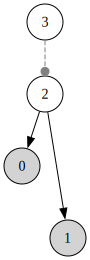

In [11]:
# creating a network that contains many child nodes are value coupled to one parent node
many_value_children_hgf = (
    Network()
    .add_nodes(precision=1e4, n_nodes=2)
    .add_nodes(value_children=[0, 1])
    .add_nodes(volatility_children=2, mean=4.0)
)

# plot the network
many_value_children_hgf.plot_network()

In [12]:
many_value_children_hgf.input_data(input_data=input_data);

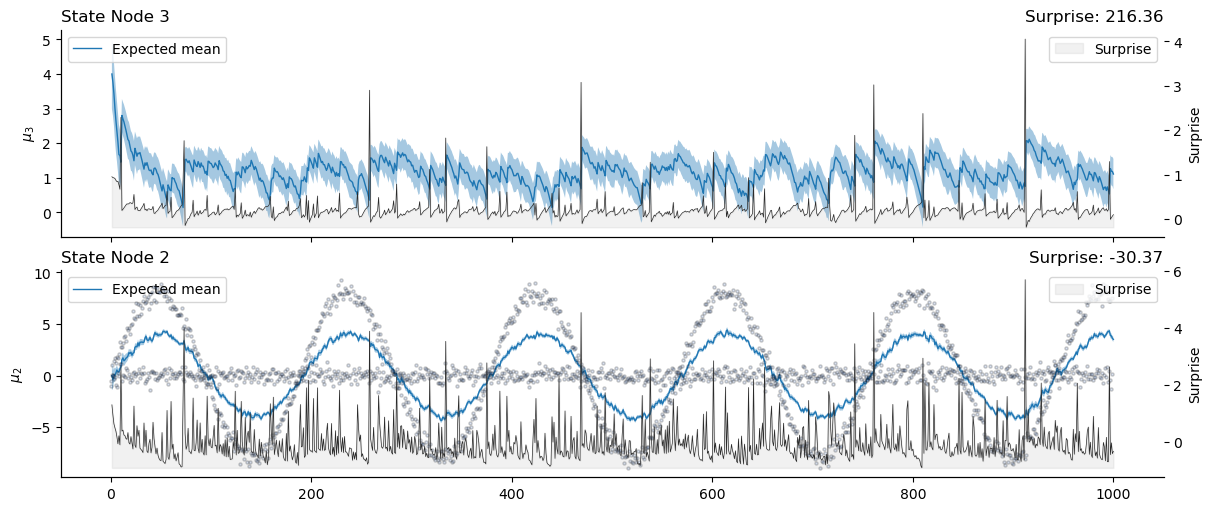

In [13]:
axs = many_value_children_hgf.plot_nodes([3, 2], figsize=(12, 5))
for i in range(2):
    axs[1].scatter(
        np.arange(0, 1000), 
        input_data[:, i],
        color="#4c72b0",
        alpha=0.2,
        s=5,
        edgecolors="k",
        zorder=10,
    )
sns.despine()

```{note}
In this figure, we can observe the joint influence of the two input nodes over the shared value parents: the shared parent tries to find a compromise between the drifts of the two child nodes.
```

##### Continuous volatility coupling

In [14]:
np.random.seed(123)

input_data = np.random.normal(0, 1, size=(1000, 2))
input_data[900:] *= 3
input_data[200:400, 0] *= 3
input_data[600:800, 1] *= 3

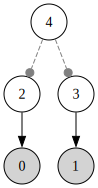

In [15]:
# creating a network that contains many child nodes that are volatility coupled to one parent node
many_volatility_children_hgf = (
    Network()
    .add_nodes(precision=1e4, n_nodes=2)
    .add_nodes(value_children=0)
    .add_nodes(value_children=1)
    .add_nodes(volatility_children=[2, 3], mean=4.0)
)

# plot the network
many_volatility_children_hgf.plot_network()

In [16]:
many_volatility_children_hgf.input_data(input_data=input_data);

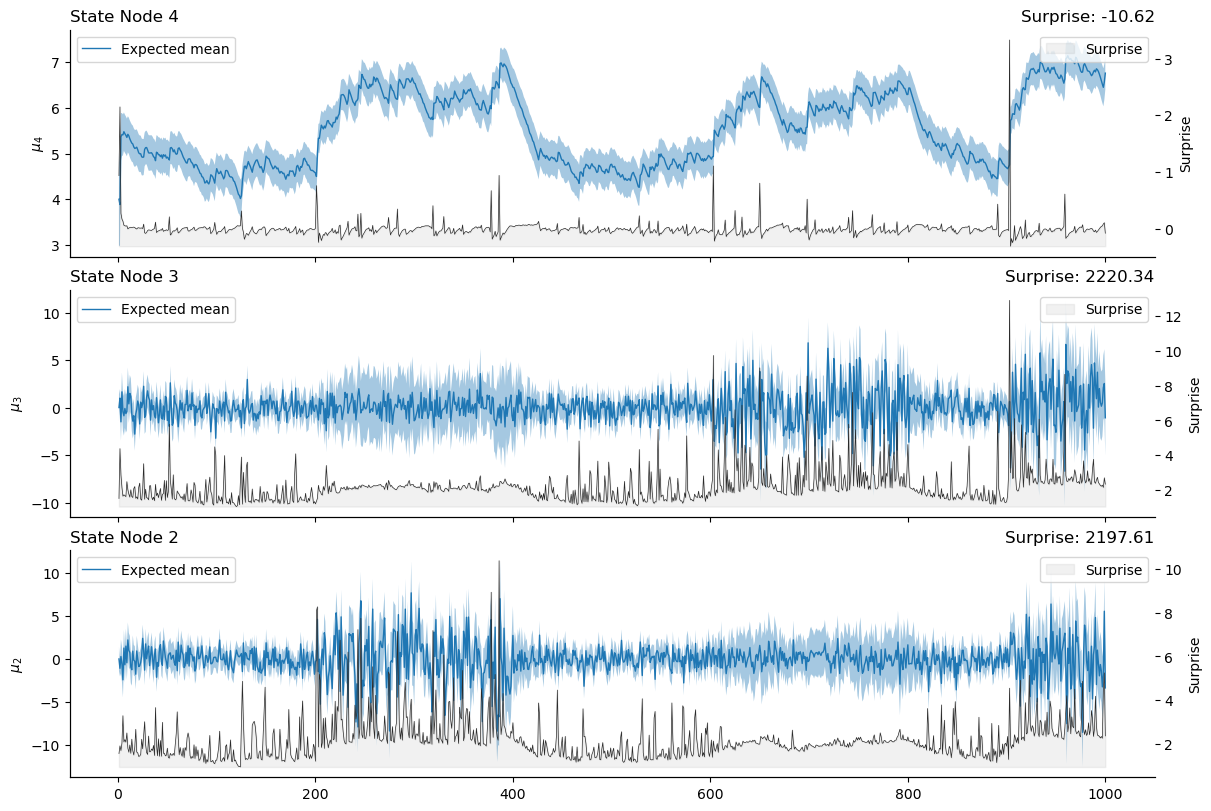

In [17]:
many_volatility_children_hgf.plot_nodes(
    [4, 3, 2],
    figsize=(12, 8),
)
sns.despine()

```{note}
In this figure, we can see that the two continuous nodes that are predicting the values of the two input nodes are directly influenced by the burst of noises alternatively appearing in the two input time series. This is reflected in changes in the underlying mean as the node tries to track the more volatile changes in the inputs, but critically, we can also observe changes around the precision of the expectations on both sides: if an input node is getting more noisy, the expectations around the second input node will also get more uncertain, and the surprise more important, due to the shared variance.
```

##### Coupling with binary nodes

In [18]:
np.random.seed(123)

# simulate two binary outcomes from sinusoidal contingencies
u_0_prob = (np.sin(np.arange(0, 1000) / 45) + 1) / 2
u_0 = np.random.binomial(p=u_0_prob, n=1)

u_1_prob = (np.sin(np.arange(0, 1000) / 90) + 1) / 2
u_1 = np.random.binomial(p=u_1_prob, n=1)

input_data = np.array([u_0, u_1]).T

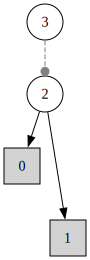

In [19]:
# creating a network that contains two binary child nodes
# value coupled to one value parent node
many_binary_children_hgf = (
    Network()
    .add_nodes(kind="binary-state", n_nodes=2)
    .add_nodes(value_children=[0, 1])
    .add_nodes(volatility_children=2)
)

# plot the network
many_binary_children_hgf.plot_network()

In [20]:
many_binary_children_hgf.input_data(input_data=input_data);

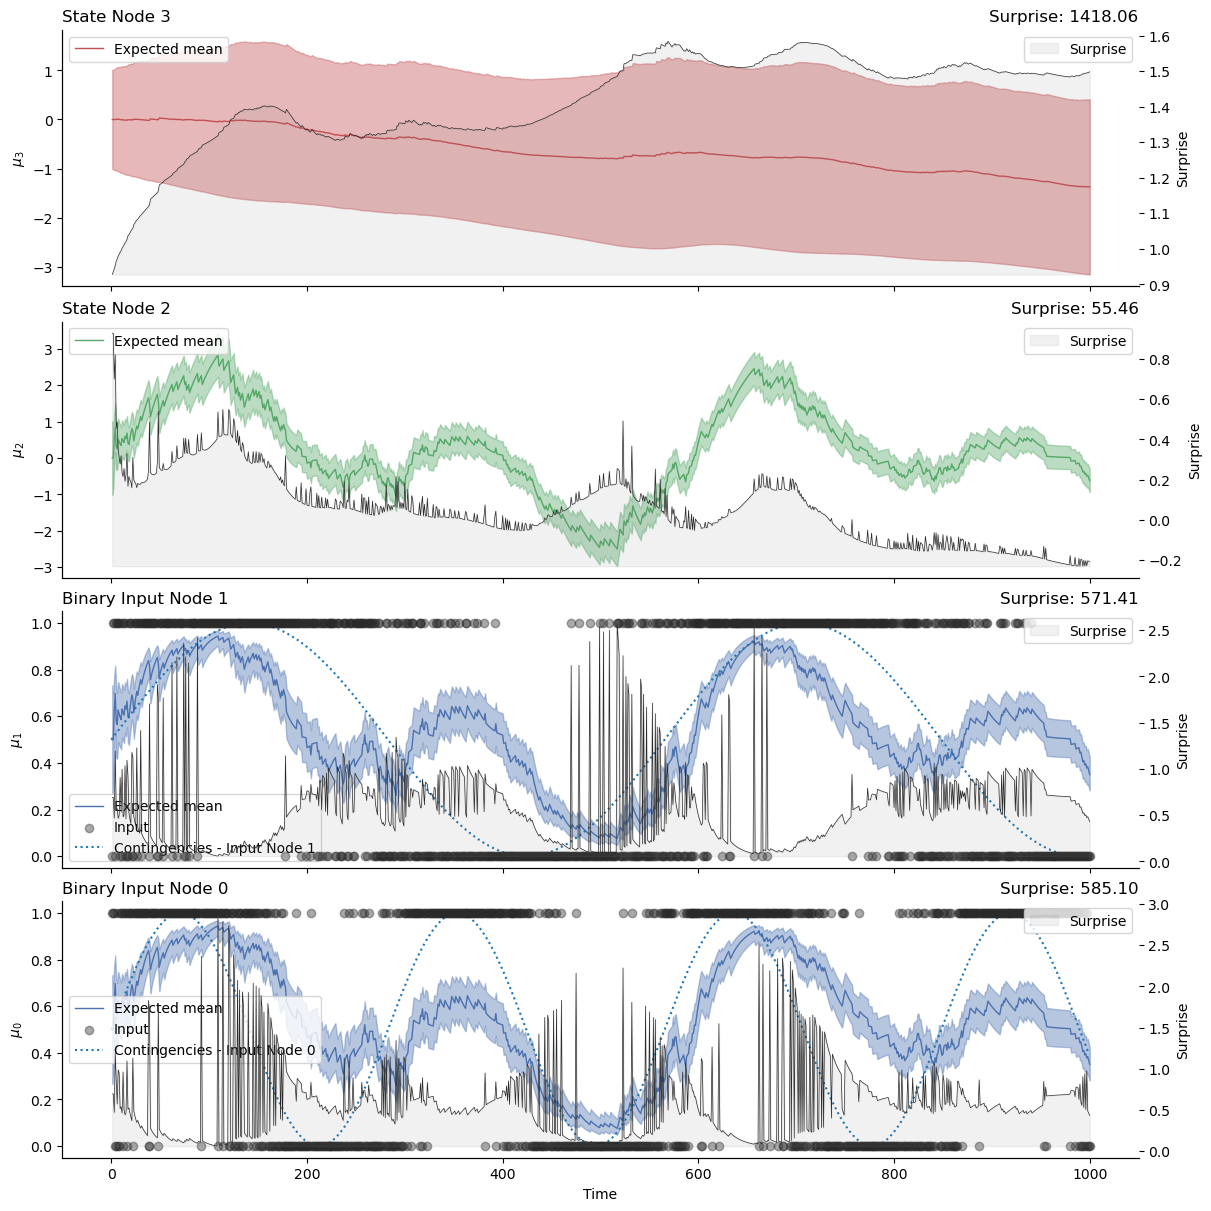

In [21]:
axs = many_binary_children_hgf.plot_trajectories(figsize=(12, 12))

# plot the real contingencies
axs[3].plot(u_0_prob, label="Contingencies - Input Node 0", linestyle=":")
axs[3].legend()
axs[2].plot(u_1_prob, label="Contingencies - Input Node 1", linestyle=":")
axs[2].legend()
sns.despine()

```{note}
This figure shows the observations received by the two binary inputs (lower panels, the lines represent the real contingencies) and their joint influence on the expected values by the shared parent (i.e. shared binary node) and the value parent of the binary node.
```

#### The case of *multivariate ascendency*

*Multivariate ascendency* refers to situations where a node is influenced (and updates backwards through prediction errors) by multiple value or volatility parents.

In [22]:
np.random.seed(123)

# simulate some time series - sampling from N(0, 1) sometime multiplied by 3
input_data = np.random.normal(0, .05, size=(1000, 2))
input_data[:, 0] += (np.sin(np.arange(0, 1000) / 45) + 1) / 2
input_data[:, 1] += (np.sin(np.arange(0, 1000) / 45) + 1) / 2

input_data[:, 1] += (np.sin(np.arange(0, 1000) / 10) + 1) / 6

#### Value coupling

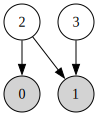

In [23]:
# creating a network with multiple volatility parents
many_value_parents_hgf = (
    Network()
    .add_nodes(
        n_nodes=2, precision=1e4,
    )
    .add_nodes(value_children=[0, 1], tonic_volatility=-6.0)
    #.add_nodes(value_children=[0], tonic_volatility=-2.0)
    .add_nodes(value_children=[1], tonic_volatility=-2.0)
)

# plot the network
many_value_parents_hgf.plot_network()

In [24]:
many_value_parents_hgf.input_data(input_data=input_data);

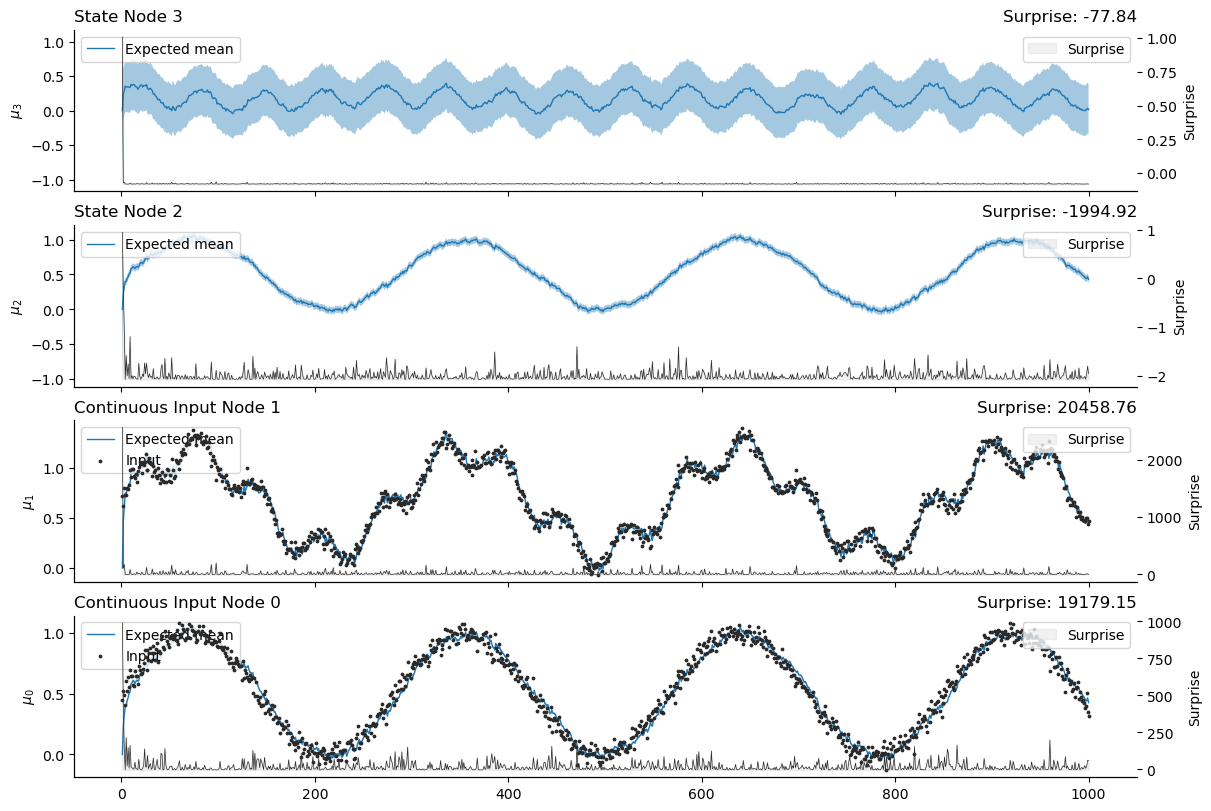

In [25]:
many_value_parents_hgf.plot_nodes(
    [3, 2, 1, 0],
    figsize=(12, 8),
)
sns.despine()

#### Volatility coupling

In [26]:
np.random.seed(123)

# simulate some time series - sampling from N(0, 1) sometime multiplied by 3
input_data = np.random.normal(0, .2, size=(2000, 2))
input_data[250:750, 0] *= 5
input_data[1000:1500, 1] *= 5

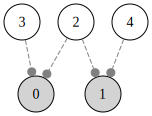

In [33]:
# creating a network with multiple volatility parents
many_volatility_parents_hgf = (
    Network()
    .add_nodes(
        n_nodes=2, precision=1e4
    )
    .add_nodes(volatility_children=[0, 1])
    .add_nodes(volatility_children=[0])
    .add_nodes(volatility_children=[1])
)

# plot the network
many_volatility_parents_hgf.plot_network()

In [34]:
many_volatility_parents_hgf.input_data(input_data=input_data);

In [35]:
many_volatility_parents_hgf.edges[0]

AdjacencyLists(node_type=2, value_parents=None, volatility_parents=(2, 3), value_children=None, volatility_children=None, coupling_fn=())

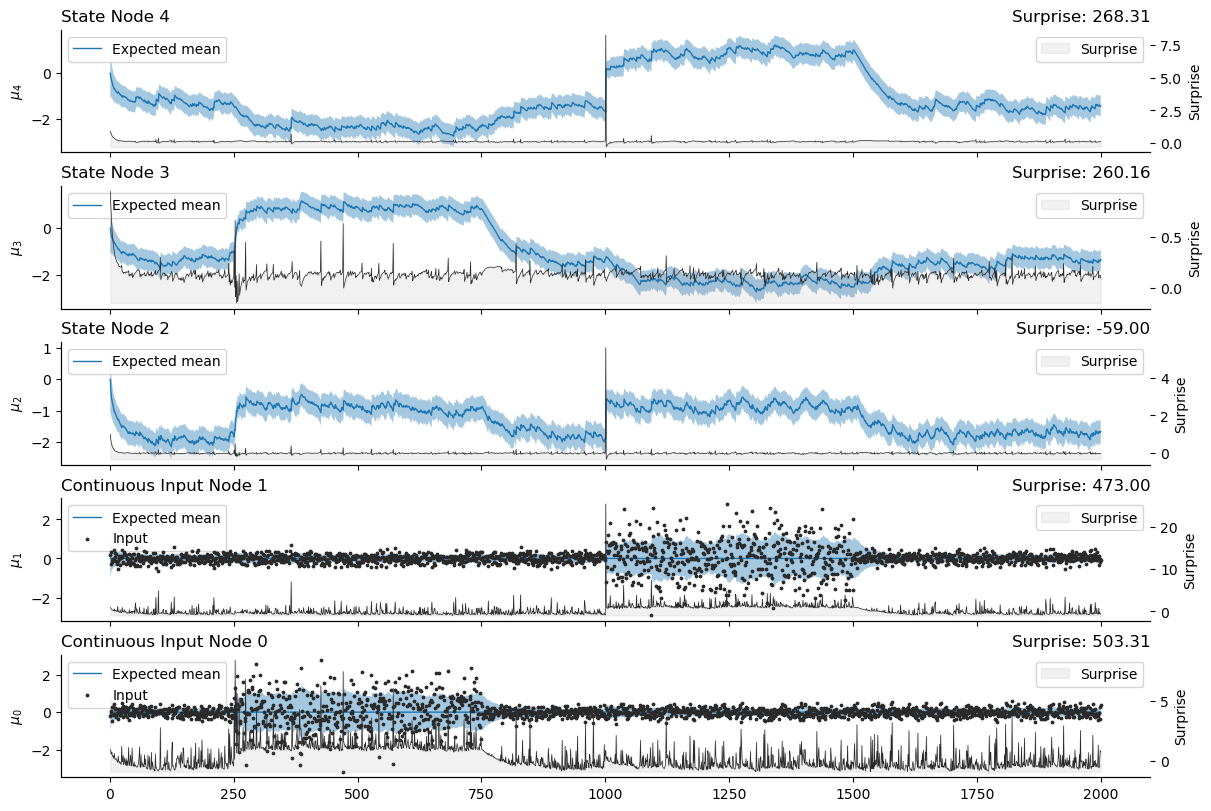

In [37]:
many_volatility_parents_hgf.plot_nodes(
    [4, 3, 2, 1, 0],
    figsize=(12, 8),
)
sns.despine()

## Creating custom update functions

The structure of the network and the node's parameters are the most static component of the network. Actually, we could consider that the network already exists once those two variables are in place. However in [pyhgf](https://ilabcode.github.io/pyhgf/index.html#) we consider that the update functions $\mathcal{F} = \{f_1, ..., f_n\}$ and the update sequence $\Sigma = [f_1(n_1), ..., f_i(n_j), f \in \mathcal{F}, n \in 1, ..., k ]$ (the order of update) are also part of the models. This choice was made to explicitly account that there is no one unique way of modelling the way beliefs propagate through the network, and a core task for predictive coding applications is to develop new *probabilistic nodes* that account for a greater variety of phenomena. This step critically requires modelling beliefs diffusion, and therefore to modify, or creating the underlying update functions.

### Update functions

Update functions are the heart of the HGF filtering procedure, these functions implement the message-passing and parameter-updating steps between nodes. An update function in its simpler form is a Python function defined as

```python
def update_fn(node_idx, attributes, edges):

    # some computation here
    # ---------------------

    return new_attributes
```

In other words, it is updating the parameters of the network by applying certain transformations using the node $i$ as a reference. This usually means that an observation has reached node $i$ and we want to send prediction error to the parent nodes and update their sufficient statistics. The function has access to the entire parameters and nodes structure, which means that it can retrieve parameters from parents, children, grandparents etc... But in practice, message-passing updates make heavy use of the mean-field approximation, which only requires accessing the most proximal nodes.

## Creating custom update sequences

Update sequences define the dynamics of beliefs propagation through the probabilistic network. In its simpler form, an update sequence is a sequence of update functions pointing to a node index such as:

```python
update_sequence = (
    (update_fn1, 0),
    (update_fn2, 1),
)
```

The HGF class include a built-in {py:func}`pyhgf.model.HGF.get_update_sequence` method to automatically generate the update sequence from the network structure, assuming that we want to propagate the beliefs from the lower part of the tree (the input nodes) to its upper part (nodes that do not have parents).

## Time-varying update sequences

### Static assignation of update sequences

```{warning}
Work in progress
```

### Dynamic assignation of update sequences

```{warning}
Work in progress
```

## Working with missing or unobserved input sequences

```{warning}
Work in progress
```

# System configuration

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Thu Sep 19 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.23.0

pyhgf : 0.1.4
jax   : 0.4.31
jaxlib: 0.4.31

IPython   : 8.23.0
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
numpy     : 1.26.0
matplotlib: 3.8.4
seaborn   : 0.13.2

Watermark: 2.4.3

